# Diffusivity of CO2 in 1k3f Polyol vs. Density of CO2

We plot the diffusivity of CO2 in the 1k3f polyol (VORATEC SD 301) as a function of the density of CO2. I have functions of each in terms of pressure, so this will just require matching those.

In [8]:
import sys
sys.path.append('../../libs/')

# imports standard libraries
import matplotlib.pyplot as plt
import numpy as np

# imports custom libraries
import polyco2
    
from importlib import reload 
reload(polyco2)

# file of polyol data from G-ADSA
polyol_data_file = '../output/1k3f_30c.csv' # must have already analyzed data to produce output
# file of CO2 density
eos_co2_file = '../input/eos/eos_co2_30-0C.csv'

# plot parameters
a_fs = 18
t_fs = 20
tk_fs = 16

### Loads Diffusivity and Density Data

In [9]:
reload(polyco2)

# loads diffusivity data (p in Pa, D in m^2/s)
p_arr, D_sqrt_arr, D_exp_arr = polyco2.load_D_arr(polyol_data_file)
D_arr = D_sqrt_arr # np.sqrt(D_sqrt_arr * D_exp_arr)

# loads CO2 density data as function that converts pressure [Pa] to density [kg/m^3] 
f_rho_co2 = polyco2.interp_rho_co2(eos_co2_file)
# computes CO2 densities [kg/m^3] at pressures for which we have diffusivity data
rho_co2 = f_rho_co2(p_arr)

# loads weight fraction data [w/w]
_, w_co2_arr = polyco2.load_w_co2_arr(polyol_data_file)

# loads concentration of CO2 in polyol phase [kg/m^3]
p_c, c_co2_arr = polyco2.load_c_s_arr(polyol_data_file, sort=False)
# removes added value of 0 from array
c_co2_arr = c_co2_arr[1:]


# identifies index at which depressurization began
i_dp = np.argmax(p_arr)

### Plot Results

Text(0.5, 1.0, 'Diffusivity of CO2 in 1k3f vs.\nCO2 Vapor-phase Density')

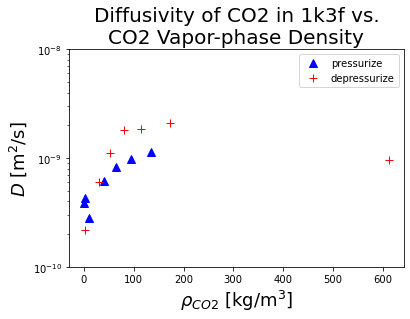

In [10]:
# creates figure
fig = plt.figure()
ax = fig.add_subplot(111)

# plots result
ax.plot(rho_co2[:i_dp], D_arr[:i_dp], 'b^', ms=8, label='pressurize')
ax.plot(rho_co2[i_dp:], D_arr[i_dp:], 'r+', ms=8, label='depressurize')
plt.legend()

# formats plot
ax.set_yscale('log')
ax.set_ylim([1E-10, 1E-8])
ax.set_xlabel(r'$\rho_{CO2}$ [kg/m$^3$]', fontsize=a_fs)
ax.set_ylabel(r'$D$ [m$^2$/s]', fontsize=a_fs)
ax.set_title('Diffusivity of CO2 in 1k3f vs.\nCO2 Vapor-phase Density', fontsize=t_fs)

Text(0.5, 1.0, 'Diffusivity of CO2 in\n1k3f vs. CO2 Weight Fraction')

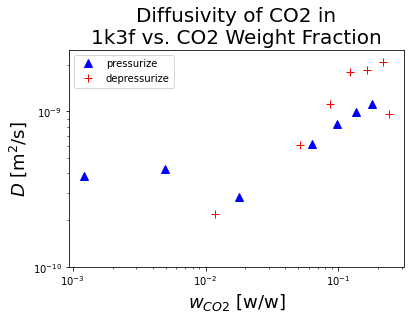

In [11]:
# creates figure
fig = plt.figure()
ax = fig.add_subplot(111)

# plots result
ax.plot(w_co2_arr[:i_dp], D_arr[:i_dp], 'b^', ms=8, label='pressurize')
ax.plot(w_co2_arr[i_dp:], D_arr[i_dp:], 'r+', ms=8, label='depressurize')
plt.legend()

# formats plot
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1E-10, 0.25E-8])
ax.set_xlabel(r'$w_{CO2}$ [w/w]', fontsize=a_fs)
ax.set_ylabel(r'$D$ [m$^2$/s]', fontsize=a_fs)
ax.set_title('Diffusivity of CO2 in\n1k3f vs. CO2 Weight Fraction', fontsize=t_fs)

Looks like the trend could be linear, but it is tough to know with the high values estimated during depressurization and the lower value at the highest weight fraction.

### Power Law Fit

Let's try a power-law fit of the form

\begin{align*}
    D(w_{CO2}) &= D(0) + Ac_{CO2}^k\\
\end{align*}

where $D(0)$ is the diffusivity of carbon dioxide in pure polyol and $A$ and $k$ are fitted parameters.

To estimate $D(0)$, we will average the values of $D$ for the lowest values of $w_{CO2}$, say, $w_{CO2} \le 0.02$. We could try fitting $D(0)$ as well, but this allows too much freedom for the model and results in non-physical values.

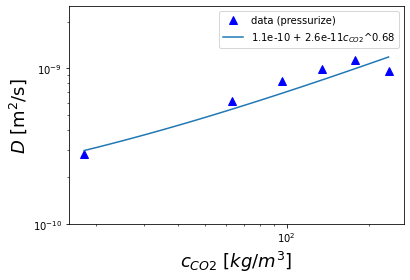

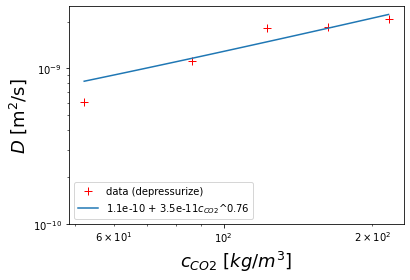

In [12]:
from scipy.optimize import least_squares

def D_co2(params, c_co2, D0):
    """Model for the diffusivity of CO2 in polyol: D(c_co2) = D0 + A*c_co2**k. """
    A, k = params
    return D0 + A*c_co2**k

def D_co2_res(params, c_co2, D, D0):
    """Computes residual from model D_co2()."""
    return 1E10*(D_co2(params, c_co2, D0) - D)

def fit_D(c_co2, D, D0, params0, label, marker='^', color='b'):
    # uses numerical solver to fit the parameters
    res_lsq = least_squares(D_co2_res, params0, args=(c_co2, D, D0))
    # extracts fitted parameters
    A, k = res_lsq.x

    # computes values for fitted function
    c_co2_fit = np.linspace(np.min(c_co2), np.max(c_co2), 100)
    D_fit = D_co2(res_lsq.x, c_co2_fit, D0)

    # plots fit against data
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(c_co2, D, color+marker, ms=8, label='data ({0:s})'.format(label))
    ax.plot(c_co2_fit, D_fit, label='{0:.2g} + {1:.2g}'.format(D0, A) + r'$c_{CO2}$^' + '{0:.2f}'.format(k))
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([1E-10, 0.25E-8])
    ax.set_xlabel(r'$c_{CO2}~[kg/m^3]$', fontsize=a_fs)
    ax.set_ylabel(r'$D$ [m$^2$/s]', fontsize=a_fs)
    ax.legend()
    
    return A, k, ax


# estimates the diffusivity a 0 concentration
D0 = np.min(np.concatenate((D_arr[:2], np.array([D_arr[-1]]))))/2

# loads data to fit parameters to
# pressurized data (includes data point at maximum pressure)
D_p = D_arr[2:i_dp+1]
c_co2_p = c_co2_arr[2:i_dp+1]
# proposes initial guesses for parameters
params0_p = (3E-9, 0.7)
# performs and plots fit
A_p, k_p, ax_p = fit_D(c_co2_p, D_p, D0, params0_p, 'pressurize')

# repeats for depressurized data
D_dp = D_arr[i_dp+1:-1]
c_co2_dp = c_co2_arr[i_dp+1:-1]
# proposes initial guesses for parameters
params0_dp = (4E-9, 0.8)
# performs and plots fit
A_dp, k_dp, ax_dp = fit_D(c_co2_dp, D_dp, D0, params0_dp, 'depressurize', marker='+', color='r')

#### Store Results of Fit in CSV File for Use by 20201124_diffn_matching.ipynb

In [15]:
import pandas as pd

df = pd.DataFrame(columns=['prop', 'p', 'dp'],
                 data=[['D0 [m^2/s]', D0, D0],
                       ['A', A_p, A_dp],
                       ['k', k_p, k_dp]])

df.to_csv('../output/1k3f_30c_D_c_power_law.csv', index=False)